In [19]:
#Import the needed packages.
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

# def Variance(feature:np.ndarray, q:float, nrepeat:int = 20):

#     samples = np.random.choice(feature, size = (nrepeat,int(feature.shape[0]*q)),)

#     return np.mean(samples.var(axis=1))


class LinearRegression():
   
    def __init__(self, Dataset: np.ndarray, nfeat: int, tar_id: int,  dx:float, μ:float, eps:float, random_state:int = -1):
        """The LinearRegression class needs a dataset it will be learning from. \\
            integer "nfeat" is a number of features we wanna include in the model. Obviously nfeat <= Dataset.shape[1].
            dx is a small, positive floating-point number for computing the derivatives of the optimizer.
            μ is so-called learning rate of the training-process.
            tar_id is the index of the target variable.
            Eps is, in turn, a division-by-zero preventing value when updating the values of the parameters."""
        
        if random_state == -1:
            self.train_set, self.test_set = train_test_split(Dataset, train_size = 0.8)
        else:
            self.train_set, self.test_set = train_test_split(Dataset, train_size = 0.8, random_state = random_state)
    

            

        self.nfeat = nfeat

        self.tar_id = tar_id
        self.dx = dx
        self.μ = μ
        self.eps = eps
        #Define the array of feature-indeces we wanna include in the model. In the end, len(sel_features) == f (True) 
        self.sel_feats = np.array([], dtype = np.int16)
        self.sel_params = np.array([], dtype = np.float64)

    #Preprocess the features before feature selections
    def FeaturePreprocessing(self, dataset:np.ndarray):
        #Declare the ThresholdVariance object
        ThresholdVariance = VarianceThreshold()
        dataset = ThresholdVariance.fit_transform(dataset)

        #Declare the MinMaxScaler object.
        Normalizator = MinMaxScaler()
        #Scale the dataset to [0;1] interval.
        dataset = Normalizator.fit_transform(dataset)
        
        return dataset
        

    #The following dataset will be a subset of the main Dataset.
    def MSE(self, dataset:np.ndarray, predictors:np.ndarray, params:np.ndarray,) -> float:
        """Computes the square root of sum of squared errors between predicted y and actual y values"""
        score = np.sum(((dataset[:, predictors] * params[1:] + params[0]).sum(axis=1) - dataset[:, self.tar_id])**2)

        return np.sqrt(score)
    

    def ComputeGradient(self, dataset:np.ndarray, predictors:np.ndarray, params:np.ndarray) -> np.ndarray:
        """The method finds the gradient (that is - the array of the values of the derivatives of all predictors)"""
        Gradient = np.zeros(params.shape[0])

        substractor = self.MSE(dataset, predictors, params)

        for i in range(params.shape[0]):
            mod_params = params.copy()
            mod_params[i] += self.dx

            Gradient[i] = (self.MSE(dataset, predictors, mod_params) - substractor)/self.dx
            

        return Gradient


    def UpdateParameters(self, dataset:np.ndarray, predictors:np.ndarray, Bm:float, Bv:float) -> np.ndarray:
        """The aim of the function is to find the set of parameters so that the MSE value is minimilized"""
        params = np.ones(shape = predictors.shape[0]+1)
        #Define the first momentum of the gradient.
        m = np.zeros(params.shape[0])
        #Define the second momentum of the gradient
        v = np.zeros(params.shape[0])


        for _ in range(1000):
            #Find the Gradient of the objective function:
            Gradient = self.ComputeGradient(dataset, predictors, params)

            #Update the values of the m.
            m = Bm*m + (1-Bm)*Gradient
            #Correct the value of the m
            m = m/(1-Bm)


            #Update the values of the v.
            v = Bv*v + (1-Bv)*Gradient**2
            #Correct the value of the v
            v = v/(1-Bv)


            #Update the parameters
            params = params - m*self.μ/(np.sqrt(v) + self.eps)


        return params
        
    #Find the score for the set of parameters.
    def FindTheScore(self, dataset:np.ndarray, predictors:np.ndarray) -> float:
        fitted_params = self.UpdateParameters(dataset, predictors, 0.3, 0.3)
        score = self.MSE(dataset, predictors, fitted_params)

    
        return (score, fitted_params)
    
    def SelectFeatures(self):
        dataset = self.FeaturePreprocessing(self.train_set)


        #--------If the scores decrease slightly, break the loop. Change it!-------

        while self.sel_feats.shape[0] < self.nfeat:
            #Initialize the variables which will store the optimal feature.
            best_feat_id:int = None
            best_feat_score :float= float('inf')
            best_params: np.ndarray = np.array([])

            is_change:bool = False

            for i in range(dataset.shape[1]):
                if i!=self.tar_id and i not in self.sel_feats:
                    sel_feats_test = np.append(self.sel_feats, i)

                    score, params = self.FindTheScore(dataset, sel_feats_test)

                    #If the  feature has lower score or equal score and greater variance,  select the feature.
                    #-----If scales of two different features are not the same, variance can be deceptive.------
                    if score < best_feat_score or (score == best_feat_score and np.var(dataset[:, i]) > np.var(dataset[:,best_feat_id ])):
                        best_feat_id = i
                        best_feat_score = score
                        best_params = params

                        is_change = True

            #If the features has been selected, append it to the set.
            if is_change:
                self.sel_feats = np.append(self.sel_feats, [best_feat_id])
                self.sel_params = best_params
            
        #Compute the final score.
        final_score  = self.MSE(self.test_set, self.sel_feats, self.sel_params)
        return self.sel_feats, self.sel_params, final_score
    




#Sprawdź na wykresie, jak liczba cech wpływa na błąd oraz jak losowy podział danych wpływa na dokładność.
#Porównaj rozwiązanie analityczne oraz numeryczne rozwiązania.
#Analityczne rozwiązanie istnieje.



### Comparison of accuracies for different numbers of included featuers.

[[  1.         135.58130316]
 [  2.         142.20339314]
 [  3.         132.18097632]
 [  4.         232.24460346]
 [  5.          84.69028438]]


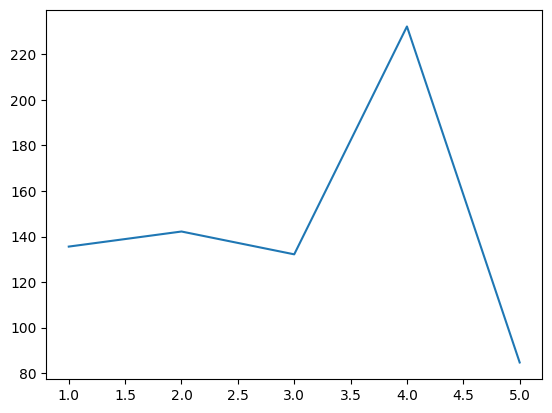

In [20]:
import polars as pl
import matplotlib.pyplot as plt



Dataset = pl.read_csv("WineQuality.csv", separator = ';', ignore_errors = True).drop_nulls()
#Define a two-feature dataset. The first feature is a number of features included, the second - the corresponding score.

nfeats = 5

Scores = np.zeros(shape = [nfeats, 2])


for nfeats in range(1,nfeats+1):
    LinReg = LinearRegression(Dataset.to_numpy(), nfeats, Dataset.shape[1]-2, 0.001, 0.001, 0.001)

    Scores[nfeats-1, 1] = LinReg.SelectFeatures()[2]
    Scores[nfeats-1, 0] = nfeats



plt.plot(Scores[:,0],Scores[:, 1])
print(Scores)





### Testowanie stabilności rozwiązania (Badanie dokładności modelu w zależności od zbioru treningowegon)

[13.9203906 14.7821934 20.6798331]


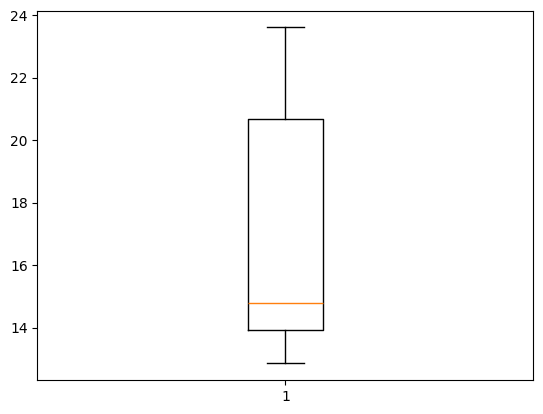

In [22]:
n = 25



Scores2 = np.zeros(shape = [n, 2],)


for i in range(n):
    LinReg_inst = LinearRegression(Dataset.to_numpy(), 1, Dataset.shape[1]-1, 0.001, 0.001, 0.001)
    Scores2[i, :] = [i,LinReg_inst.SelectFeatures()[2]]

    
Scores2


plt.boxplot(x = Scores2[:, 1])
print(np.quantile(Scores2[:, 1], q  =[0.25, 0.5, 0.75]))
 